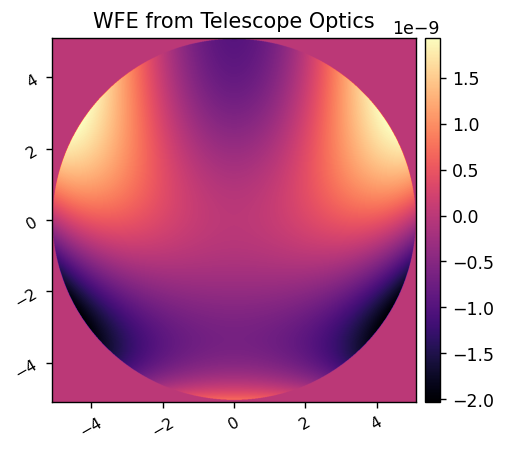

In [1]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import fdpr2

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from prop_models import full, agpm
import misc_funs as misc
reload(full)

pupil_diam = 10.2*u.mm
wavelength_c = 750e-9*u.m

lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

hdr = fits.getheader('wfe_on_axis.fits')
ote_wfe = poppy.FITSOpticalElement(opd='wfe_on_axis.fits', opdunits='meters',
                                   pixelscale=pupil_diam.to_value(u.m)/hdr['NAXIS1'])
misc.imshow1(ote_wfe.opd, 'WFE from Telescope Optics', pxscl=ote_wfe.pixelscale.to(u.mm/u.pix))

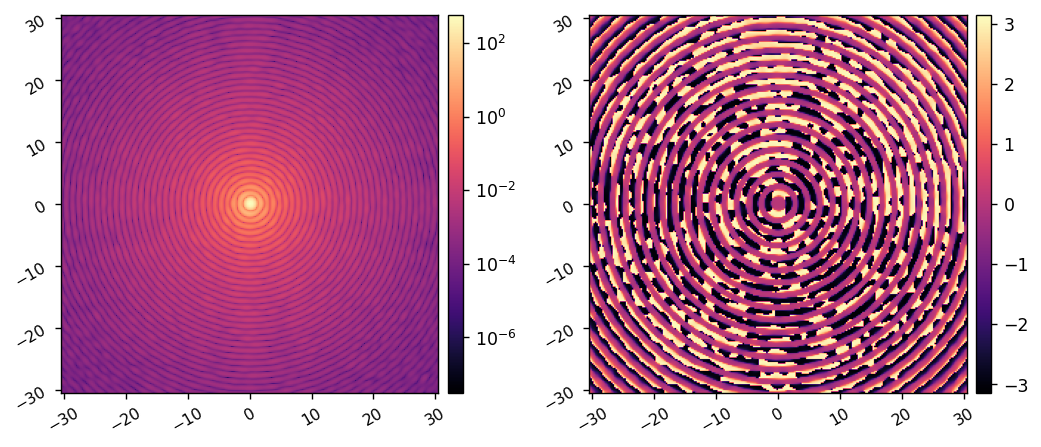

In [16]:
reload(full)
reload(misc)
poppy_log.disabled = True

vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=3*u.mm, gray_pixel=False)

c = full.CORO()

c.npix = 128
c.oversample = 16
c.npsf = 256
c.use_opds = True
c.OTEWFE = ote_wfe

c.norm = 'none'
# c.FPM = vortex
# c.LYOT = lyot_stop

# c.set_dm(np.ones(c.DM.shape)*wavelength_c.value)
# c.defocus = wavelength_c.to(u.mm)

# wf = c.calc_wfs()[-1]
# psf = wf.wavefront

focus_psf = c.calc_psf()
misc.imshow2(np.abs(focus_psf)**2, np.angle(focus_psf),
             pxscl=c.psf_pixelscale_lamD, 
             lognorm1=True)

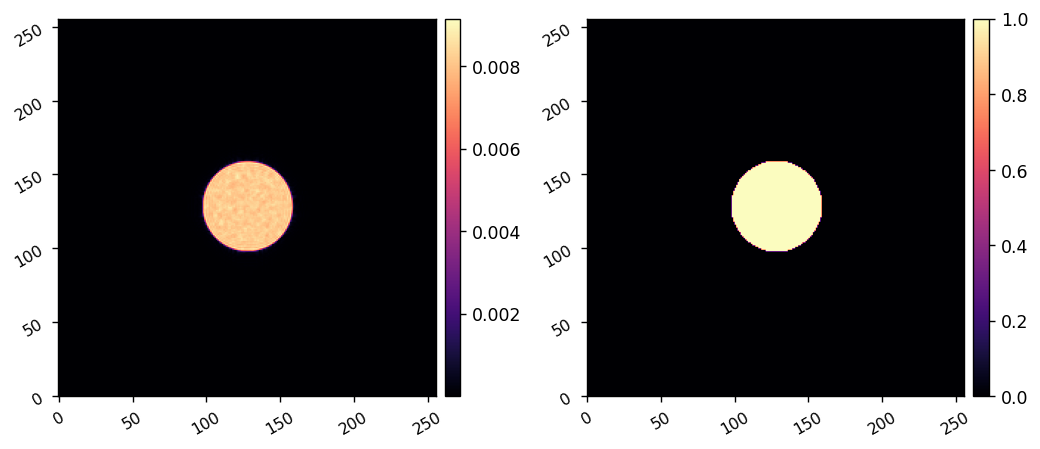

In [17]:
# pupil_fft = np.abs(utils.ifft2_shiftnorm(focus_psf))
pupil_fft = np.abs(np.fft.ifftshift(np.fft.ifft2(focus_psf)))
thresh = 0.002
fitmask = pupil_fft > thresh

misc.imshow2(pupil_fft, fitmask)

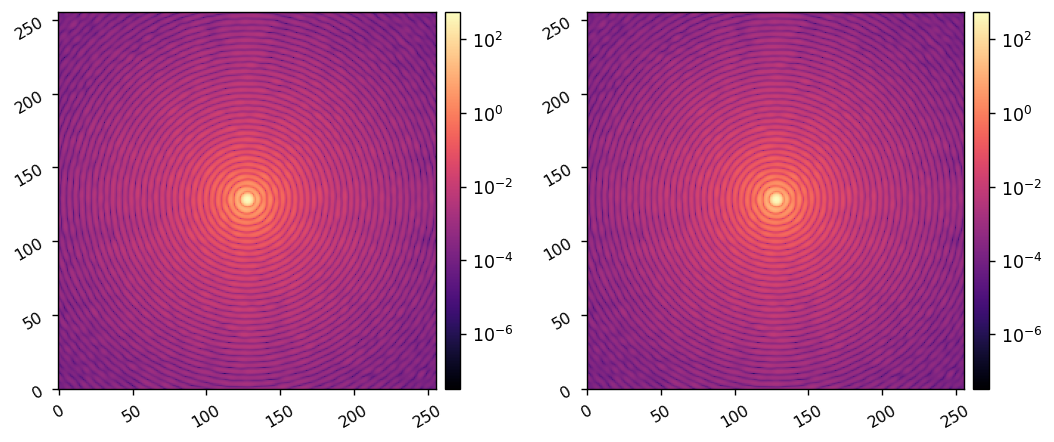

In [18]:
c.defocus = wavelength_c.to(u.mm)
defocus_im1 = c.snap()

c.defocus = -1/2*wavelength_c.to(u.mm)
defocus_im2 = c.snap()

misc.imshow2(defocus_im1, defocus_im2, 
             lognorm=True)

defocus_vals = np.array([wavelength_c.value, -wavelength_c.value/2])
defocus_ims = np.array([defocus_im1, defocus_im2])

In [19]:
tol = 1e-6
reg = 0
wreg = 10
modes = poppy.zernike.arbitrary_basis(cp.array(fitmask), nterms=100, outside=0).get()


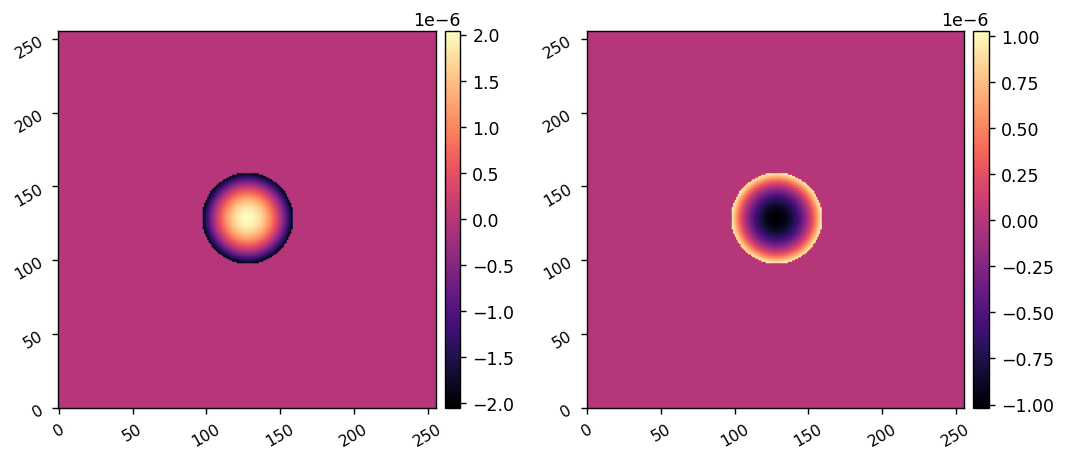

In [20]:
reload(fdpr2)
# Ediv = fdpr2.get_defocus_probes(fitmask, -0.25 * np.asarray(model_params['vals_defocus']))
Ediv = fdpr2.get_defocus_probes(fitmask, -0.25 * defocus_vals)
misc.imshow2(np.angle(Ediv[0]), np.angle(Ediv[1]))

In [24]:
reload(fdpr2)

prdict = fdpr2.run_phase_retrieval(defocus_ims, fitmask, tol, reg, wreg, Ediv, modes=modes, fit_amp=True)


In [25]:
prdict

{'phase_est': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'amp_est': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'obj_val': 0.00040698546766737564,
 'fit_params': array([ 9.99845631e-01,  6.81722625e-07,  1.55087306e-03,  0.00000000e+00,
         7.31189415e-04,  6.49141057e-04,  0.00000000e+00,  0.00000000e+00,
         1.01106118e-03,  1.29036013e-04,  0.00000000e+00,  2.98728453e-03,
         0.00000000e+00,  0.00000000e+00,  1.26814370e-03,  0.00000000e+00,
         1.23973506e-04,  0.00000000e+00,  3.96052258e-06,  1.17552636e-04,
         1.31593525e-05,  7.09739239e-03,  3.329

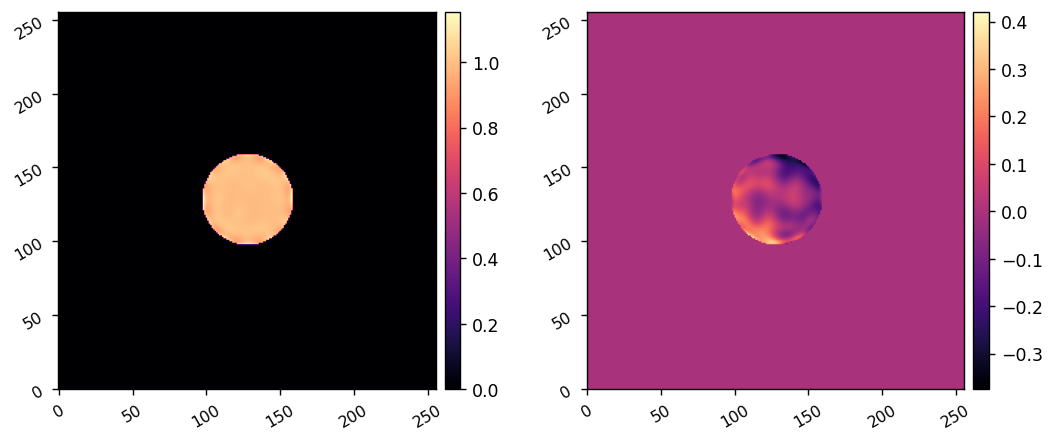

In [27]:
misc.imshow2(prdict['amp_est'], prdict['phase_est'])

In [84]:
type(tol)

float